# Multiclass Semantic Segmentation using CamVid dataset

In [1]:
#Importing libraries
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

import os
import shutil

import random
from sklearn.utils import shuffle

## Check system environment


In [2]:
print("Tensorflow version: ",tf.__version__)

print("Is GPU available: {}".format(tf.test.is_gpu_available()))

W0313 20:02:38.737150 11496 deprecation.py:323] From <ipython-input-2-d03a236d2262>:3: is_gpu_available (from tensorflow.python.framework.test_util) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Tensorflow version:  2.1.0
Is GPU available: True


## Data preparation - Import data, clean and creating structured directory


### Function to import and process frames and mask as tensors

## Image directory and size parameters 

In [3]:
img_dir = "..\data\CamSeq01"

#Required image dimensions
IMG_HEIGHT = 256
IMG_WIDTH = 256
INPUT_CHANNELS =3

DEBUG = True



## Reading frames and masks
. Mask file names end with "_L.png"

In [4]:
def separate_data_from_labels(img_dir):
    '''
    '''
#     regexp_path = str(os.path.join(img_dir,"*"))
#     list_ds = tf.data.Dataset.list_files(regexp_path)    
#     for f in list_ds.take(5):
#         print(f.numpy())

    #Get all the file names list from the directory
    all_file_list = [f for f in os.listdir(img_dir) if f.endswith(".png")]
    print("Total PNG files in the folder: {}".format(len(all_file_list)))
    
    # Get actual images
    frame_files_list =[os.path.join(img_dir,f) for f in all_file_list if "_L" not in f]

    image_count = len(frame_files_list)
    # Get masks - Get the files with _L in their name
    mask_files_list =[os.path.join(img_dir,f) for f in all_file_list if "_L" in f]
    
    print("Trainable frames in the folder: {}".format(image_count))
    print("Mask images in the folder: {}".format(len(mask_files_list)))

#     data_list_ds = tf.data.Dataset.from_tensor_slices(img_files_list)
#     mask_list_ds = tf.data.Dataset.from_tensor_slices(mask_files_list)

    
    return frame_files_list, mask_files_list

# read_images(img_dir)
frame_files_list, mask_files_list = separate_data_from_labels(img_dir)


Total PNG files in the folder: 202
Trainable frames in the folder: 101
Mask images in the folder: 101


In [5]:
# Make the train validation folder

folders = ['train_frames\\frames', 'train_masks\\masks', 'val_frames\\frames', 'val_masks\\masks']

for folder in folders:
    try:
        os.makedirs(os.path.join(img_dir,folder))
    except Exception as ex:
        print(ex)
        

train_frames_folder = os.path.join(img_dir,'train_frames')
train_masks_folder = os.path.join(img_dir,'train_masks')


validation_frames_folder = os.path.join(img_dir,'val_frames')
validation_masks_folder = os.path.join(img_dir,'val_masks')
    
        
    

[WinError 183] Cannot create a file when that file already exists: '..\\data\\CamSeq01\\train_frames\\frames'
[WinError 183] Cannot create a file when that file already exists: '..\\data\\CamSeq01\\train_masks\\masks'
[WinError 183] Cannot create a file when that file already exists: '..\\data\\CamSeq01\\val_frames\\frames'
[WinError 183] Cannot create a file when that file already exists: '..\\data\\CamSeq01\\val_masks\\masks'


### Separate out the files into folders

In [6]:
if len(os.listdir(os.path.join(train_frames_folder,'frames')))==0:

    validation_fraction = 0.2
    total_samples = len(frame_files_list)

    num_validation_samples = int(np.ceil(validation_fraction*total_samples))
    num_training_samples = total_samples - num_validation_samples
    print("Total samples: {}".format(total_samples))

    # Get random indices for separating the validation samples

    idx_range = np.arange(total_samples)
    shuffled_idx = shuffle(idx_range, random_state=33)
    print(shuffled_idx)
    
    # print(shuffled_idx)
    idx_validation = shuffled_idx[:num_validation_samples]
    idx_train = shuffled_idx[num_validation_samples:]

    # Move the validation and trainng samples to the correct folders

    # Move training frames
    [shutil.copy(frame_files_list[i], os.path.join(train_frames_folder,'frames',os.path.split(frame_files_list[i])[-1])) for i in idx_train]

    # Move training masks
    [shutil.copy(mask_files_list[i], os.path.join(train_masks_folder,'masks',os.path.split(mask_files_list[i])[-1])) for i in idx_train]


    # Move validation frames
    [shutil.copy(frame_files_list[i], os.path.join(validation_frames_folder,'frames',os.path.split(frame_files_list[i])[-1])) for i in idx_validation]

    # Move validation masks
    [shutil.copy(mask_files_list[i], os.path.join(validation_masks_folder,'masks',os.path.split(mask_files_list[i])[-1])) for i in idx_validation]

    print("File copying complete")
    
else:
    print("Training / validation folders already exists, not copying files")
    num_training_samples = len(os.listdir(os.path.join(train_frames_folder,'frames')))
    num_validation_samples = len(os.listdir(os.path.join(validation_frames_folder,'frames')))

idx_range = np.arange(100)
shuffled_idx = shuffle(idx_range, random_state=33)
# print(shuffled_idx)

print("Num training samples: {}".format(num_training_samples))
print("Num validation samples: {}".format(num_validation_samples))
        

Training / validation folders already exists, not copying files
Num training samples: 80
Num validation samples: 21


### Extract the labels for each class
The masks have RGB triplets for each class. I need to modify this into class ids


In [7]:
labels_fname = os.path.join(img_dir,'label_colors.txt')

dict_idx_class = {}
dict_idx_rgb =   {}

with open(labels_fname) as fp:
    for cnt,line in enumerate(fp):
        
        # Separate componenets of each line. The name is separate from the rgb triplet by a tab
        x =line.split("\t")
        rgb_value = x[0]
        
        # Need the RGB in int not as a string
        rgb_value = tuple(int(i) for i in rgb_value.split(" "))

        # Extract the class names
        class_name = x[-1].rstrip()
        
#         print("Line number: {}, class: {}, rgb triplet: {}".format(cnt,class_name,rgb_value))
        
        #Create a dictionary of idx-name pairs
        dict_idx_class[cnt]=class_name
        dict_idx_rgb[cnt]=rgb_value

n_classes = len(dict_idx_class)
print("Number of classes in the image: {}".format(n_classes))


Number of classes in the image: 32


In [8]:
print("Idx to class dictionary:")
dict_idx_class


Idx to class dictionary:


{0: 'Animal',
 1: 'Archway',
 2: 'Bicyclist',
 3: 'Bridge',
 4: 'Building',
 5: 'Car',
 6: 'CartLuggagePram',
 7: 'Child',
 8: 'Column_Pole',
 9: 'Fence',
 10: 'LaneMkgsDriv',
 11: 'LaneMkgsNonDriv',
 12: 'Misc_Text',
 13: 'MotorcycleScooter',
 14: 'OtherMoving',
 15: 'ParkingBlock',
 16: 'Pedestrian',
 17: 'Road',
 18: 'RoadShoulder',
 19: 'Sidewalk',
 20: 'SignSymbol',
 21: 'Sky',
 22: 'SUVPickupTruck',
 23: 'TrafficCone',
 24: 'TrafficLight',
 25: 'Train',
 26: 'Tree',
 27: 'Truck_Bus',
 28: 'Tunnel',
 29: 'VegetationMisc',
 30: 'Void',
 31: 'Wall'}

In [9]:
print("Idx to rgb triplet dictionary:")
dict_idx_rgb


Idx to rgb triplet dictionary:


{0: (64, 128, 64),
 1: (192, 0, 128),
 2: (0, 128, 192),
 3: (0, 128, 64),
 4: (128, 0, 0),
 5: (64, 0, 128),
 6: (64, 0, 192),
 7: (192, 128, 64),
 8: (192, 192, 128),
 9: (64, 64, 128),
 10: (128, 0, 192),
 11: (192, 0, 64),
 12: (128, 128, 64),
 13: (192, 0, 192),
 14: (128, 64, 64),
 15: (64, 192, 128),
 16: (64, 64, 0),
 17: (128, 64, 128),
 18: (128, 128, 192),
 19: (0, 0, 192),
 20: (192, 128, 128),
 21: (128, 128, 128),
 22: (64, 128, 192),
 23: (0, 0, 64),
 24: (0, 64, 64),
 25: (192, 64, 128),
 26: (128, 128, 0),
 27: (192, 128, 192),
 28: (64, 0, 64),
 29: (192, 192, 0),
 30: (0, 0, 0),
 31: (64, 192, 0)}

### Create functions for converting onehot vectors into the colormap and colormap into onehot vectors 

In [10]:
def rgb_to_onehot(rgb_image,dict_idx_rgb):
    '''
    Take a rgb label image and return a onehot image as input with h x w x n_classes
    '''
    
    rgb_image =rgb_image.astype(np.int)
    # Create empty array of size m x n x n_classes
    onehot_image = np.zeros((rgb_image.shape[0],rgb_image.shape[1],n_classes),dtype=np.uint8)

    # assign True depending on the rgb triplet
    for idx in range(n_classes):
        onehot_image[:,:,idx] = np.all(rgb_image.reshape(-1,3) == dict_idx_rgb[idx],axis=1).reshape(rgb_image.shape[:2])
    
#     print(onehot_image[:,:,4])        
#     print(onehot_image.shape)    
    return onehot_image


def onehot_to_rgb(onehot_image,dict_idx_rgb):
    '''
    Take a onehot image as input with h x w x n_classes, and return a rgb image
    '''
    
    #Get 1 channel image
    onehot_single_channel = np.argmax(onehot_image,axis=-1) 
    
    rgb_image = np.zeros((onehot_image.shape[0],onehot_image.shape[1],3),dtype=np.uint8)

    for i in dict_idx_rgb.keys():
#         rgb_image[onehot_single_channel==i] == dict_idx_rgb[i]

        rgb_image[onehot_single_channel==i] = dict_idx_rgb[i]

#     print(np.max(np.argmax(onehot_image,axis=2)))
#     print(onehot_single_channel)

    return rgb_image 
    
# out = rgb_to_onehot(mask_array[0], dict_idx_rgb)    
# out = onehot_to_rgb(np.zeros((256,256,32)), dict_idx_rgb)    
# plt.imshow(out[:,:,4])


### Use the ImageDataGenerators for creating batches of data for training and validation

Note that, in this case, I can't use the keras iamge generator as is. The mask image is in rgb triplets.
This triplet data has to be converted into class idx/ onehot matrices before being sent to the training model.


In [11]:
frame_gen_args = dict(rescale=1./255)
mask_gen_args = dict()

train_frame_generator = keras.preprocessing.image.ImageDataGenerator(**frame_gen_args)
train_mask_generator = keras.preprocessing.image.ImageDataGenerator(**mask_gen_args)

validate_frame_generator = keras.preprocessing.image.ImageDataGenerator(**frame_gen_args)
validate_mask_generator = keras.preprocessing.image.ImageDataGenerator(**mask_gen_args)


### Create the custom image data generator

In [12]:
def TrainingDataGenerator(seed=1, batch_size=5):
    
    # Use the ImageGenerator syntax to get data from directory
    print("In TrainingDataGenerator ")
    
    train_frames_data = train_frame_generator.flow_from_directory(train_frames_folder,
                                                          seed=seed,
                                                          batch_size=batch_size)
    
    train_masks_data = train_mask_generator.flow_from_directory(train_masks_folder,
                                                          seed=seed,
                                                          batch_size=batch_size)
    
    # Extract a batch of data
    current_batch_frames = train_frames_data.next()
    current_batch_masks  = train_masks_data.next()
    
    # Create the out array for 1 hot encoding
    onehot_batch_masks = np.zeros(current_batch_masks[0].shape[0:3]+(n_classes,))
    
    #From this batch, modify the mask so that the n x height x width x 3 data is transformed into n x height x width x n_classes
    # Create the generator
    while 1:
        for i in range(batch_size):
            onehot_batch_masks[i] = rgb_to_onehot(current_batch_masks[0][i],dict_idx_rgb)
        
#         print("onehot_batch_masks shape: ",onehot_batch_masks.shape)
        yield current_batch_frames[0],onehot_batch_masks
        


def ValidationDataGenerator(seed=1, batch_size=5):
    
    # Use the ImageGenerator syntax to get data from directory
    print("In ValidationDataGenerator ")
    
    train_frames_data = train_frame_generator.flow_from_directory(validation_frames_folder,
                                                          seed=seed,
                                                          batch_size=batch_size)
    
    train_masks_data = train_mask_generator.flow_from_directory(validation_masks_folder,
                                                          seed=seed,
                                                          batch_size=batch_size)
    
    # Extract a batch of data
    current_batch_frames = train_frames_data.next()
    current_batch_masks  = train_masks_data.next()
    
    # Create the out array for 1 hot encoding
    onehot_batch_masks = np.zeros(current_batch_masks[0].shape[0:3]+(n_classes,))
    
    #From this batch, modify the mask so that the n x height x width x 3 data is transformed into n x height x width x n_classes
    # Create the generator
    while 1:
        for i in range(batch_size):
            onehot_batch_masks[i] = rgb_to_onehot(current_batch_masks[0][i],dict_idx_rgb)
        
#         print("onehot_batch_masks shape: ",onehot_batch_masks.shape)
        yield current_batch_frames[0],onehot_batch_masks
        


        
# Testing 

if DEBUG:
    
    print("Testing TrainingDataGenerator")
    m_batch = TrainingDataGenerator()
    test_batch = next(m_batch)
    im_array = test_batch[0]
    onehot_array = test_batch[1]

    print("im_array shape: ", im_array.shape)
    print("onehot_array shape: ", onehot_array.shape)

    print("Testing ValidationDataGenerator")

    m_batch = ValidationDataGenerator()


    test_batch = next(m_batch)
    im_array = test_batch[0]
    onehot_array = test_batch[1]

    print("im_array shape: ", im_array.shape)
    print("onehot_array shape: ", onehot_array.shape)



Testing TrainingDataGenerator
In TrainingDataGenerator 
Found 80 images belonging to 1 classes.
Found 80 images belonging to 1 classes.
im_array shape:  (5, 256, 256, 3)
onehot_array shape:  (5, 256, 256, 32)
Testing ValidationDataGenerator
In ValidationDataGenerator 
Found 21 images belonging to 1 classes.
Found 21 images belonging to 1 classes.
im_array shape:  (5, 256, 256, 3)
onehot_array shape:  (5, 256, 256, 32)


### Display some of the images  

In TrainingDataGenerator 
Found 80 images belonging to 1 classes.
Found 80 images belonging to 1 classes.


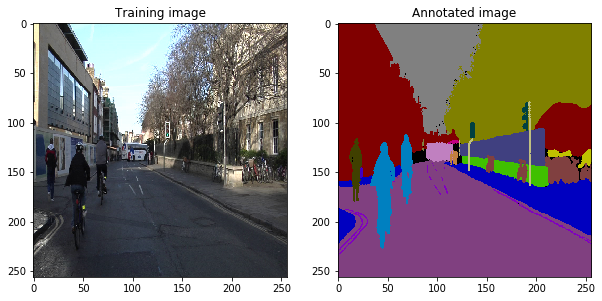

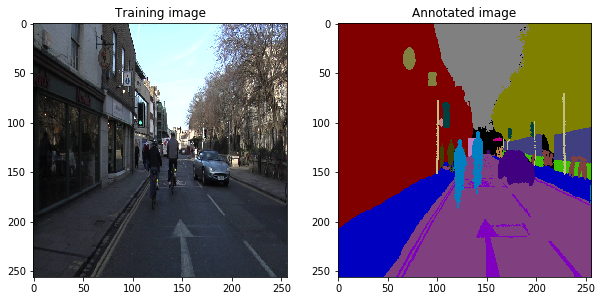

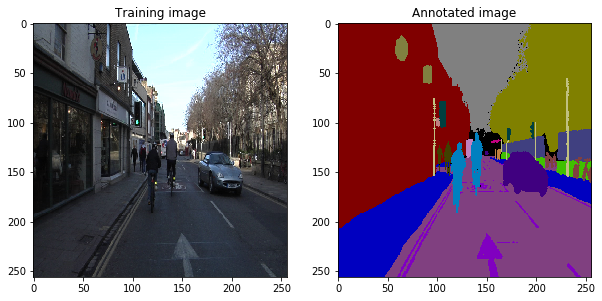

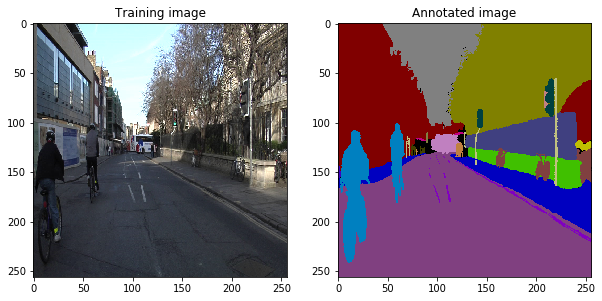

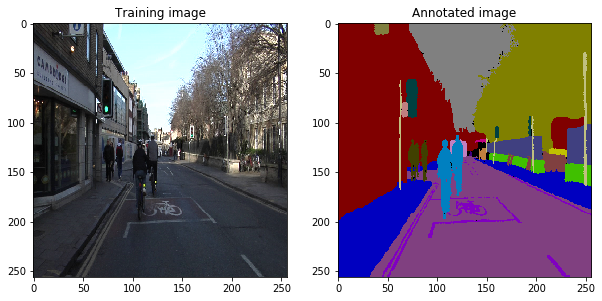

In [13]:
m_batch = TrainingDataGenerator()
test_batch = next(m_batch)

im_array = test_batch[0]
onehot_array = test_batch[1]

for i in range(5):
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(im_array[i])
    plt.title("Training image")
    plt.subplot(1,2,2)
    plt.imshow(onehot_to_rgb(onehot_array[i],dict_idx_rgb))
    plt.title("Annotated image")
    

## U Net architecture 

Text(0.5, 1.0, 'U-Net architecture')

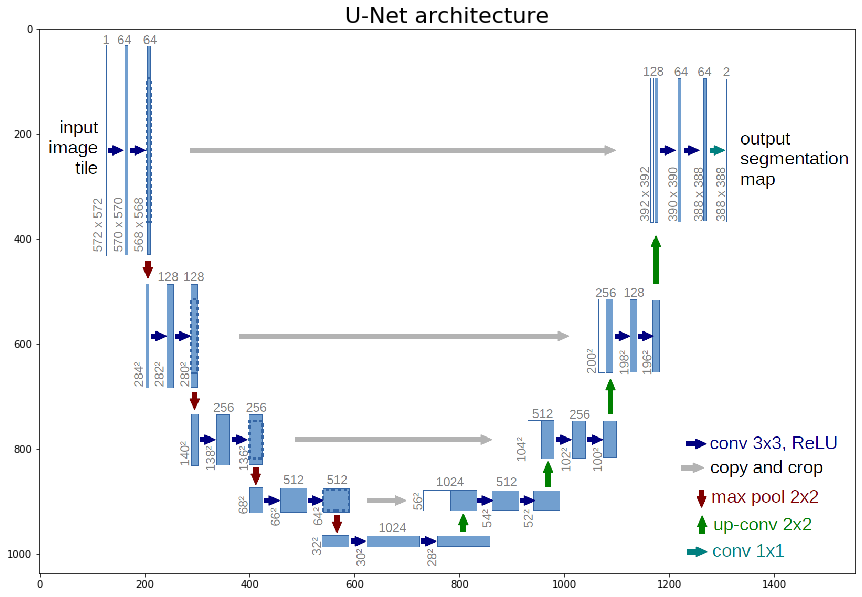

In [14]:
#Show the structure
img = plt.imread("../images/u-net-architecture.png")

plt.figure(figsize=(20,10))
plt.imshow(img)
plt.title("U-Net architecture", fontsize=22)

In [15]:
DROPOUT_FRACTION =0.2

# Build the model using the functional API
def build_UNET(flag_use_bn =True):

    #Encoder part
    #Block 1
    input_ = keras.layers.Input(shape=(IMG_HEIGHT,IMG_WIDTH,INPUT_CHANNELS))
#     c1 = keras.layers.Conv2D(16,kernel_size=(3,3) , kernel_initializer='he_normal', padding='same')(input_)
    c1 = keras.layers.Conv2D(16,kernel_size=(3,3), kernel_initializer='he_normal', padding='same')(input_)
    
    if(flag_use_bn):
        # Apply BN before the activation
        c1 = keras.layers.BatchNormalization()(c1)
    c1 = keras.layers.Activation("relu")(c1)
        
    c1 = keras.layers.Conv2D(16,(3,3) , kernel_initializer='he_normal',padding='same')(c1)    
    if(flag_use_bn):
        # Apply BN before the activation
        c1 = keras.layers.BatchNormalization()(c1)
    c1 = keras.layers.Activation("relu")(c1)

    #Block 2
    p1 = keras.layers.MaxPool2D((2,2))(c1)
    p1 = keras.layers.Dropout(DROPOUT_FRACTION)(p1)
    c2 = keras.layers.Conv2D(32,(3,3) , kernel_initializer='he_normal',padding='same')(p1)
    if(flag_use_bn):
        # Apply BN before the activation
        c2 = keras.layers.BatchNormalization()(c2)
    c2 = keras.layers.Activation("relu")(c2)

    c2 = keras.layers.Conv2D(32,(3,3) , kernel_initializer='he_normal',padding='same')(c2)
    if(flag_use_bn):
        # Apply BN before the activation
        c2 = keras.layers.BatchNormalization()(c2)
    c2 = keras.layers.Activation("relu")(c2)

    #Block 3
    p2 = keras.layers.MaxPool2D((2,2))(c2)
    p2 = keras.layers.Dropout(DROPOUT_FRACTION)(p2)
    c3 = keras.layers.Conv2D(64,(3,3) , kernel_initializer='he_normal',padding='same')(p2)
    if(flag_use_bn):
        # Apply BN before the activation
        c3 = keras.layers.BatchNormalization()(c3)
    c3 = keras.layers.Activation("relu")(c3)

    c3 = keras.layers.Conv2D(64,(3,3) , kernel_initializer='he_normal',padding='same')(c3)
    if(flag_use_bn):
        # Apply BN before the activation
        c3 = keras.layers.BatchNormalization()(c3)
    c3 = keras.layers.Activation("relu")(c3)

    #Block 4
    p3 = keras.layers.MaxPool2D((2,2))(c3)
    p3 = keras.layers.Dropout(DROPOUT_FRACTION)(p3)
    c4 = keras.layers.Conv2D(128,(3,3) , kernel_initializer='he_normal',padding='same')(p3)
    if(flag_use_bn):
        # Apply BN before the activation
        c4 = keras.layers.BatchNormalization()(c4)
    c4 = keras.layers.Activation("relu")(c4)

    c4 = keras.layers.Conv2D(128,(3,3) , kernel_initializer='he_normal',padding='same')(c4)
    if(flag_use_bn):
        # Apply BN before the activation
        c4 = keras.layers.BatchNormalization()(c4)
    c4 = keras.layers.Activation("relu")(c4)

    #Block 5
    p4 = keras.layers.MaxPool2D((2,2))(c4)
    p4 = keras.layers.Dropout(DROPOUT_FRACTION)(p4)
    c5 = keras.layers.Conv2D(256,(3,3) , kernel_initializer='he_normal',padding='same')(p4)
    if(flag_use_bn):
        # Apply BN before the activation
        c5 = keras.layers.BatchNormalization()(c5)
    c5 = keras.layers.Activation("relu")(c5)

    c5 = keras.layers.Conv2D(256,(3,3) , kernel_initializer='he_normal',padding='same')(c5)
    if(flag_use_bn):
        # Apply BN before the activation
        c5 = keras.layers.BatchNormalization()(c5)
    c5 = keras.layers.Activation("relu")(c5)


    #Decoder part

    #Block 6
    u1 = keras.layers.Conv2DTranspose(128,(2,2), strides=(2,2) ,padding='same')(c5)
    u1 = keras.layers.concatenate([c4, u1])
    c6 = keras.layers.Conv2D(128,(3,3) , kernel_initializer='he_normal',padding='same')(u1)
    if(flag_use_bn):
        # Apply BN before the activation
        c6 = keras.layers.BatchNormalization()(c6)
    c6 = keras.layers.Activation("relu")(c6)


    c6 = keras.layers.Conv2D(128,(3,3) , kernel_initializer='he_normal',padding='same')(c6)
    if(flag_use_bn):
        # Apply BN before the activation
        c6 = keras.layers.BatchNormalization()(c6)
    c6 = keras.layers.Activation("relu")(c6)

    #Block 7
    u2 = keras.layers.Conv2DTranspose(64,(2,2), strides=(2,2), activation='relu',padding='same')(c6)
    u2 = keras.layers.concatenate([c3,u2])
    c7 = keras.layers.Conv2D(64,(3,3) , kernel_initializer='he_normal',padding='same')(u2)
    if(flag_use_bn):
        # Apply BN before the activation
        c7 = keras.layers.BatchNormalization()(c7)
    c7 = keras.layers.Activation("relu")(c7)

    c7 = keras.layers.Conv2D(64,(3,3) , kernel_initializer='he_normal',padding='same')(c7)
    if(flag_use_bn):
        # Apply BN before the activation
        c7 = keras.layers.BatchNormalization()(c7)
    c7 = keras.layers.Activation("relu")(c7)

    #Block 8
    u3 = keras.layers.Conv2DTranspose(32,(3,3), strides=(2,2), activation='relu',padding='same')(c7)
    u3 = keras.layers.concatenate([c2,u3])
    c8 = keras.layers.Conv2D(32,(3,3) , kernel_initializer='he_normal',padding='same')(u3)
    if(flag_use_bn):
        # Apply BN before the activation
        c8 = keras.layers.BatchNormalization()(c8)
    c8 = keras.layers.Activation("relu")(c8)

    c8 = keras.layers.Conv2D(32,(3,3) , kernel_initializer='he_normal',padding='same')(c8)
    if(flag_use_bn):
        # Apply BN before the activation
        c8 = keras.layers.BatchNormalization()(c8)
    c8 = keras.layers.Activation("relu")(c8)

    #Block 9
    u4 = keras.layers.Conv2DTranspose(16,(2,2), strides=(2,2), activation='relu',padding='same')(c8)
    u4 = keras.layers.concatenate([c1,u4])
    c9 = keras.layers.Conv2D(16,(3,3) , kernel_initializer='he_normal',padding='same')(u4)
    if(flag_use_bn):
        # Apply BN before the activation
        c9 = keras.layers.BatchNormalization()(c9)
    c9 = keras.layers.Activation("relu")(c9)

    c9 = keras.layers.Conv2D(16,(3,3) , kernel_initializer='he_normal',padding='same')(c9)
    if(flag_use_bn):
        # Apply BN before the activation
        c9 = keras.layers.BatchNormalization()(c9)
    c9 = keras.layers.Activation("relu")(c9)

    #Final layer
    c10 = keras.layers.Conv2D(32,(3,3),activation='softmax',padding='same')(c9)
#     c10 = keras.layers.Conv2D(1,(3,3),activation=None,padding='same')(c9)

    outputs = c10

    model = keras.Model(inputs=[input_],outputs=[outputs], name='U-Net')
    
    
    return model


In [16]:
model = build_UNET(flag_use_bn=False)

model.summary()



Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        activation[0][0]                 
______________________________________________________________________________________________

In [17]:

model_folder_name = "unet_camvid"
model_name = model_folder_name + ".h5"


#ModelCheckpoint - Save only the best model
save_model_filepath = os.path.join(os.path.abspath(os.pardir),"models",model_folder_name,model_name)

print("ModelCheckpoint Callback saves the model in: {}".format(save_model_filepath))

checkpoint_cb = keras.callbacks.ModelCheckpoint(save_model_filepath,
                                               save_best_only=True)

# Early stopping.
# ModelCheckpoint will save best, but wont stop training, which might go on for a long time and consume resources.
# Early stoppoing callback helps with this
# early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
#                                                      patience=10,
#                                                      restore_best_weights=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)

#Create a custom callback if needed. For example, display the ratio of validation loss / training_loss to detect overfitting
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs):
        print("\n Custom Callback - Epoch: {}, val/train loss ratio: {:.2f}".format(epoch, logs["val_loss"] / logs["loss"]))

#Instance of the custom callback
print_ratio_cb = PrintValTrainRatioCallback()

#Tensorboard callback

#Note:
#For windows, forward and back slahses are painful to get right for the tensorboard usage.
# What works is that create a windows path, and replace the \ with \\

#Save data in models folder.
root_logdir = os.path.join(os.pardir, "models", model_folder_name, "tensorboard", "my_logs")
print("Tensorboard parent logs folder: {}".format(root_logdir))

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d_%H_%M_%S")
    return os.path.join(root_logdir,run_id)

run_logdir = get_run_logdir()
print("Current logdir: {}".format(run_logdir))

tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

callbacks=[checkpoint_cb,early_stopping_cb, tensorboard_cb]


ModelCheckpoint Callback saves the model in: C:\Users\abhat\research\Tensorflow_2.0_tutorials\models\unet_camvid\unet_camvid.h5
Tensorboard parent logs folder: ..\models\unet_camvid\tensorboard\my_logs
Current logdir: ..\models\unet_camvid\tensorboard\my_logs\run_2020_03_13_20_02_46


## Dice Loss 

In [18]:
# Ref: salehi17, "Twersky loss function for image segmentation using 3D FCDN"
# -> the score is computed for each class separately and then summed
# alpha=beta=0.5 : dice coefficient
# alpha=beta=1   : tanimoto coefficient (also known as jaccard)
# alpha+beta=1   : produces set of F*-scores
# implemented by E. Moebel, 06/04/18
def tversky_loss(y_true, y_pred):
    alpha = 0.5
    beta  = 0.5
    
    ones = K.ones(K.shape(y_true))
    p0 = y_pred      # proba that voxels are class i
    p1 = ones-y_pred # proba that voxels are not class i
    g0 = y_true
    g1 = ones-y_true
    
    num = K.sum(p0*g0, (0,1,2,3))
    den = num + alpha*K.sum(p0*g1,(0,1,2,3)) + beta*K.sum(p1*g0,(0,1,2,3))
    
    T = K.sum(num/den) # when summing over classes, T has dynamic range [0 Ncl]
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T

In [19]:
# Create Dice loss
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f*y_true_f) + K.sum(y_pred_f*y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.-dice_coef(y_true, y_pred)

smooth =1.0

In [20]:
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=[dice_coef,'accuracy'])

In [21]:
batch_size = 5
steps_per_epoch = int(np.ceil(num_training_samples / batch_size))
steps_per_epoch

16

In [22]:

validation_steps = int(np.ceil(num_validation_samples /batch_size))
validation_steps

5

In [23]:
num_epochs = 100

In [24]:
# Train model

batch_size = 5
result = model.fit_generator(TrainingDataGenerator(),
                             steps_per_epoch=steps_per_epoch ,
                             validation_data = ValidationDataGenerator(), 
                             validation_steps = validation_steps,
                             epochs=num_epochs,
                             callbacks=callbacks)

# model.save_weights("camvid_model_150_epochs.h5", overwrite=True)

W0313 20:02:46.392704 11496 deprecation.py:323] From <ipython-input-24-1986f1b59a1c>:9: Model.fit_generator (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
Please use Model.fit, which supports generators.


In TrainingDataGenerator 
Found 80 images belonging to 1 classes.
Found 80 images belonging to 1 classes.


W0313 20:02:47.087671 11496 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


In ValidationDataGenerator 
Found 21 images belonging to 1 classes.
Found 21 images belonging to 1 classes.


W0313 20:02:47.798880 11496 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


Train for 16 steps, validate for 5 steps
Epoch 1/100
16/16 [==============================] - 8s 470ms/step - loss: 3.1492 - dice_coef: 0.1196 - accuracy: 0.1389 - val_loss: 2.4728 - val_dice_coef: 0.2232 - val_accuracy: 0.1625
Epoch 2/100
16/16 [==============================] - 5s 289ms/step - loss: 2.2952 - dice_coef: 0.2602 - accuracy: 0.2136 - val_loss: 2.1479 - val_dice_coef: 0.2741 - val_accuracy: 0.2026
Epoch 3/100
16/16 [==============================] - 5s 305ms/step - loss: 2.0714 - dice_coef: 0.2976 - accuracy: 0.2646 - val_loss: 1.9364 - val_dice_coef: 0.3225 - val_accuracy: 0.3611
Epoch 4/100
16/16 [==============================] - 4s 271ms/step - loss: 1.7665 - dice_coef: 0.4059 - accuracy: 0.4343 - val_loss: 1.5946 - val_dice_coef: 0.4650 - val_accuracy: 0.4478
Epoch 5/100
16/16 [==============================] - 5s 289ms/step - loss: 1.4251 - dice_coef: 0.5475 - accuracy: 0.5642 - val_loss: 1.3833 - val_dice_coef: 0.5496 - val_accuracy: 0.5760
Epoch 6/100
16/16 [=====

In [25]:
print(result.history)

{'loss': [3.1491806656122208, 2.2951770573854446, 2.0713955610990524, 1.7664992362260818, 1.4251316711306572, 1.1595526859164238, 0.8834857791662216, 0.7965062484145164, 0.6090884879231453, 0.49625270813703537, 0.42566083185374737, 0.36781177297234535, 0.3173166960477829, 0.2813531868159771, 0.2500932337716222, 0.22265860252082348, 0.2042126040905714, 0.1855796054005623, 0.17235220782458782, 0.1593530224636197, 0.14630366768687963, 0.13846140168607235, 0.1291580032557249, 0.1271163411438465, 0.11653026612475514, 0.10914011439308524, 0.1020761001855135, 0.10001107817515731, 0.09664851240813732], 'dice_coef': [0.11964936, 0.26024082, 0.2975969, 0.4058717, 0.54749966, 0.6701048, 0.7652161, 0.7918207, 0.8473973, 0.87671906, 0.8945015, 0.909459, 0.92163837, 0.93077105, 0.9384146, 0.94534695, 0.9498206, 0.9543187, 0.9573077, 0.9604404, 0.96354926, 0.9653097, 0.96766526, 0.9680325, 0.97062546, 0.97250515, 0.9742545, 0.97466755, 0.975419], 'accuracy': [0.13887577, 0.2135868, 0.26458186, 0.4343

dict_keys(['loss', 'dice_coef', 'accuracy', 'val_loss', 'val_dice_coef', 'val_accuracy'])


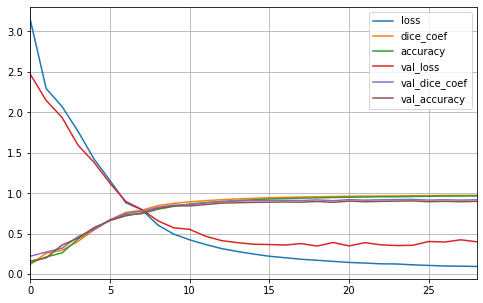

In [26]:
# Plot the history
import pandas as pd

print(result.history.keys())

pd.DataFrame(result.history).plot(figsize=(8,5))
plt.grid(True)
# plt.gca().set_ylim(0,10)

In [27]:
testing_gen = ValidationDataGenerator()



In [28]:
batch_img,batch_mask = next(testing_gen)
pred_all= model.predict(batch_img)
np.shape(pred_all)

In ValidationDataGenerator 
Found 21 images belonging to 1 classes.
Found 21 images belonging to 1 classes.


(5, 256, 256, 32)

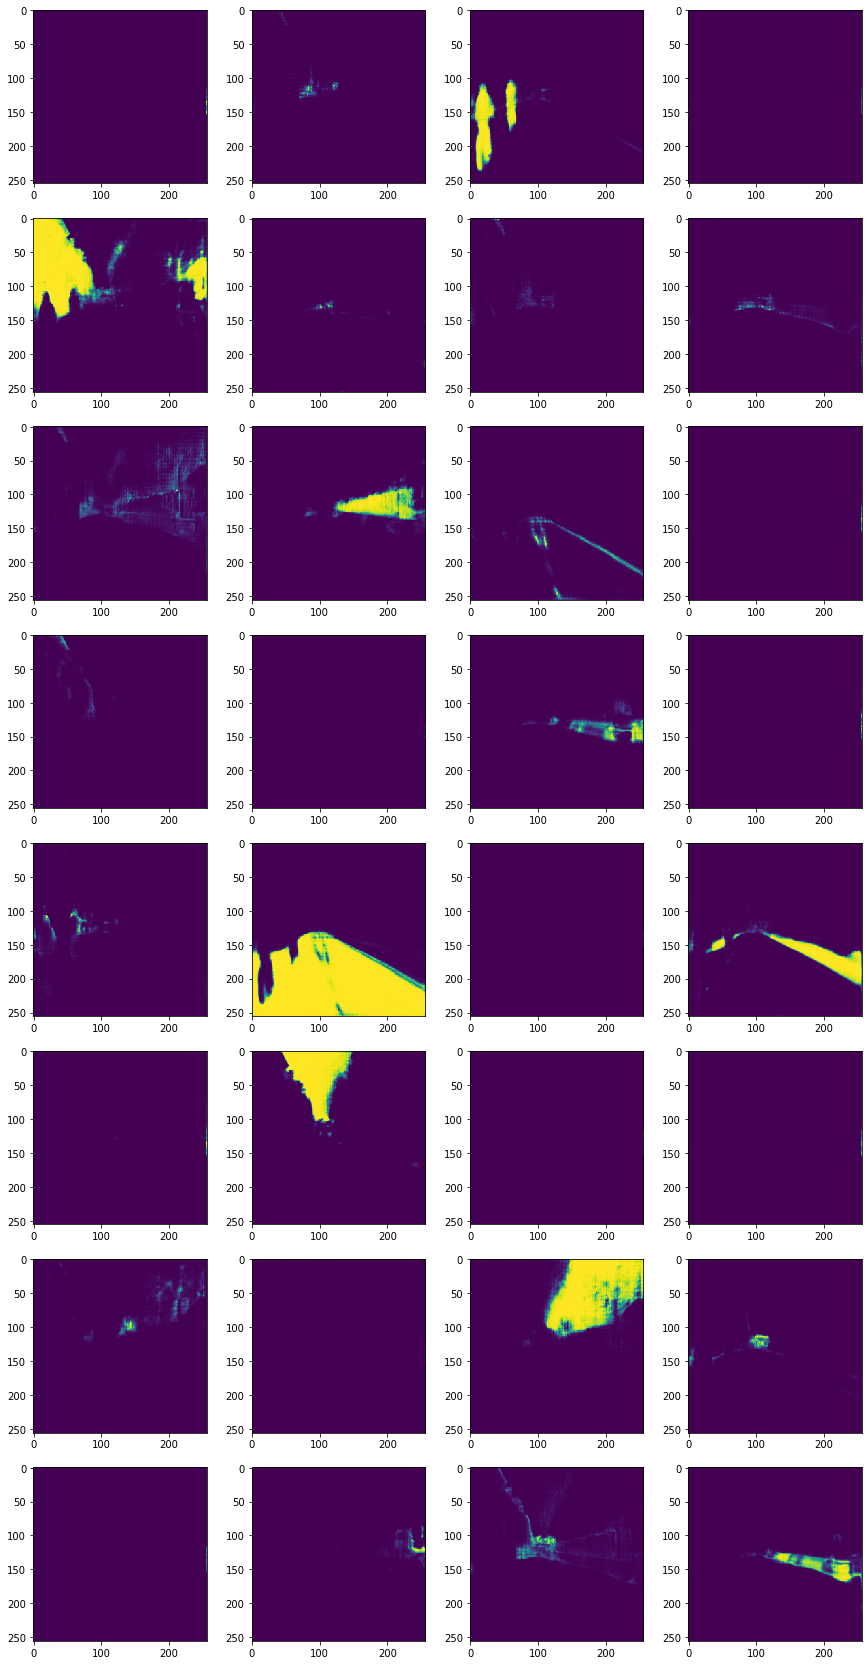

In [29]:
# out = onehot_to_rgb(pred_all[0],dict_idx_rgb)
# out.shape

plt.figure(figsize=(15,30))

for i in range(32):
    plt.subplot(8,4,i+1)
    plt.imshow(pred_all[0,:,:,i])
    
    

In [30]:
# print(pred_all[0].shape)

# # out = onehot_to_rgb(pred_all[0],dict_idx_rgb)
# # out.shape

# onehot_image = pred_all[0]
# onehot_single_channel = np.argmax(onehot_image,axis=-1) 
# print("onehot_single_channel:{}".format(onehot_single_channel.shape))
# # print(onehot_single_channel)



# rgb_image = np.zeros((onehot_image.shape[0],onehot_image.shape[1],3),dtype=np.uint8)
# print("rgb_image shape:{}".format(rgb_image.shape))

# i=4
# # print(dict_idx_rgb[i])
# # print(rgb_image)    

# # print(onehot_single_channel==i)
# # print(rgb_image)
# # rgb_image.reshape[-1,3] [onehot_single_channel==i]
# # print(asd.shape)
# for i in dict_idx_rgb.keys():
#     rgb_image[onehot_single_channel==i] = dict_idx_rgb[i]

# #     print(np.sum(onehot_single_channel==i))
# #     print(onehot_single_channel==i)
# #     rgb_image[onehot_single_channel==i,] = dict_idx_rgb
    
# #     print(i)
# #     rgb_image[onehot_single_channel==i] == dict_idx_rgb[i]

# print(rgb_image)    

# plt.imshow(rgb_image)

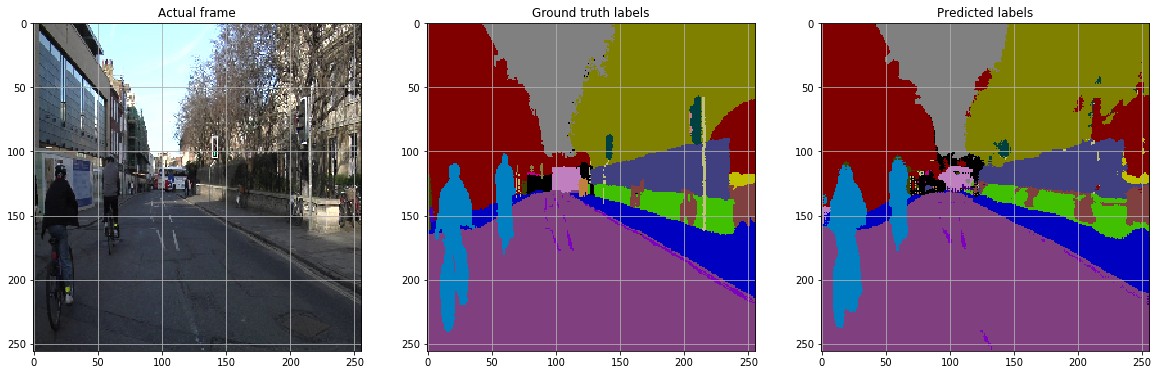

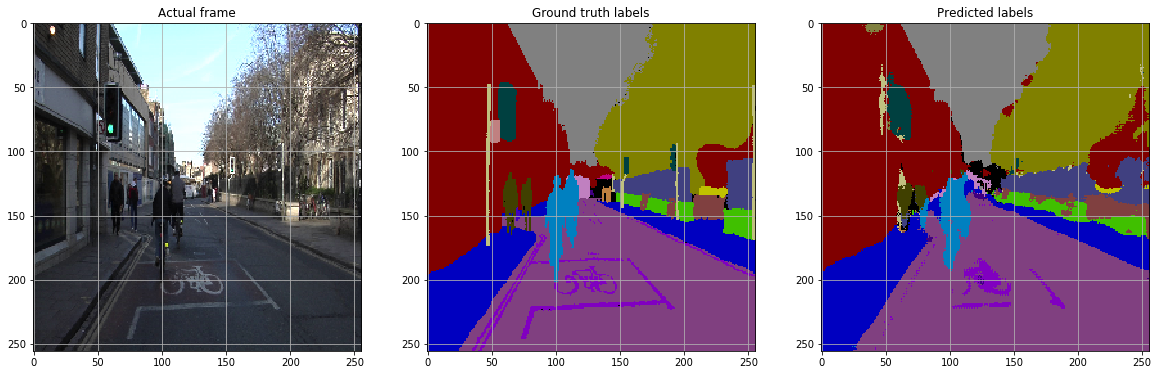

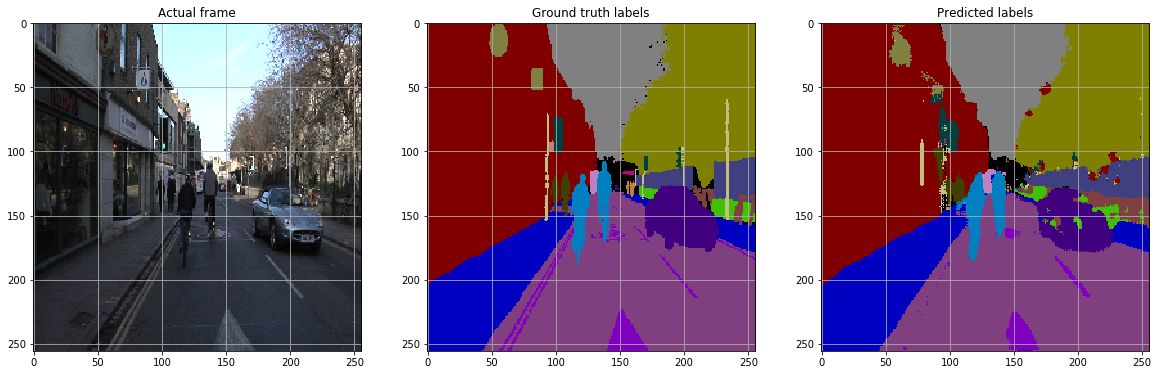

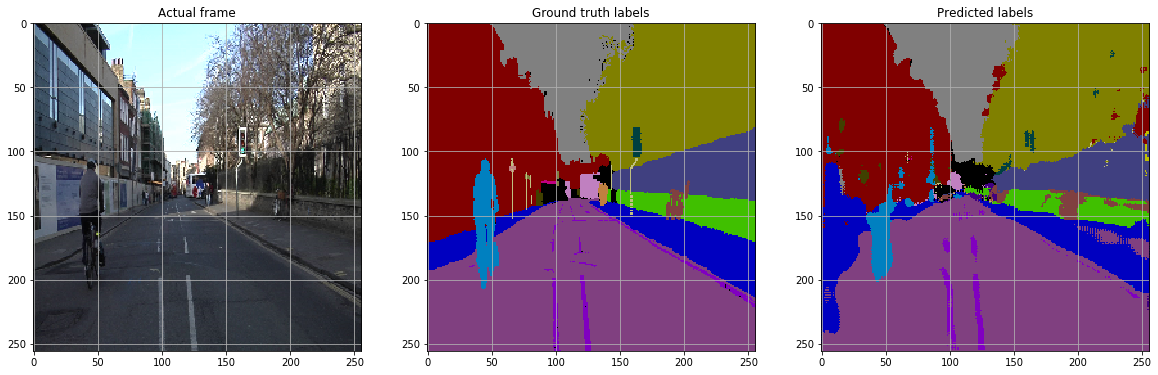

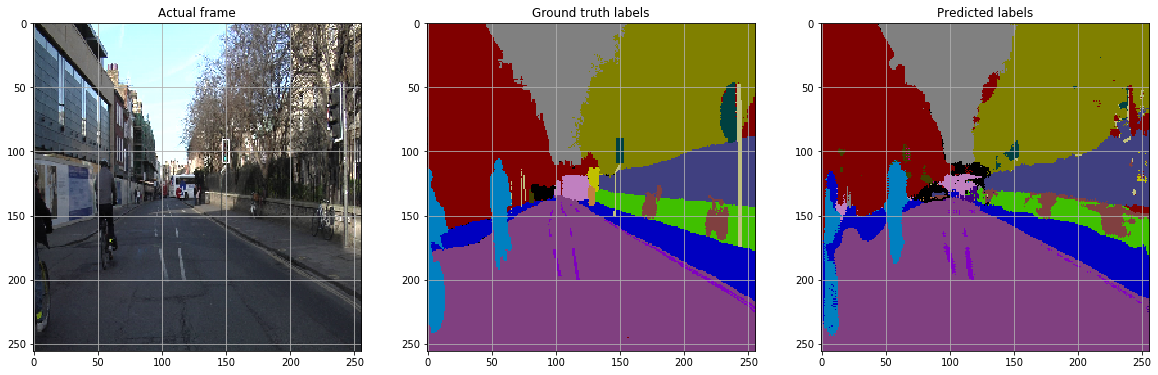

(5, 256, 256, 32)


In [31]:
for i in range(0,np.shape(pred_all)[0]):
    
    fig = plt.figure(figsize=(20,8))
    
    ax1 = fig.add_subplot(1,3,1)
    ax1.imshow(batch_img[i])
    ax1.title.set_text('Actual frame')
    ax1.grid(b=None)
    
    
    ax2 = fig.add_subplot(1,3,2)
    ax2.set_title('Ground truth labels')
    ax2.imshow(onehot_to_rgb(batch_mask[i],dict_idx_rgb))
    ax2.grid(b=None)
    
    ax3 = fig.add_subplot(1,3,3)
    ax3.set_title('Predicted labels')
    
    ax3.imshow(onehot_to_rgb(pred_all[i],dict_idx_rgb))
    ax3.grid(b=None)
    
    plt.show()

print(pred_all.shape)
